In [ ]:
!jt -t chesterish

In [ ]:
'''
To change the theme use the following command:
!jt -t <theme-name>

Theme names: 
1) chesterish 
2) onedork  (currently using)
    !jt -t onedork -f roboto -fs 12
3) monokai
 more here: https://github.com/dunovank/jupyter-themes
 
 other: https://towardsdatascience.com/bringing-the-best-out-of-jupyter-notebooks-for-data-science-f0871519ca29
'''

Now that we have gathered all the data, its time to clean and prepare them for our clustering algorithm

In [1]:
%run packages_imported.py
%run EDA.py
%run NLP.py
%run Cleaner.py

In [2]:
pd.options.display.max_colwidth = 1000

Load the dataset

In [ ]:
''' FOR SMALLER DF - NEEDS TO GO AT THE BEGINNING
frame1 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'entertainment'][:1200]
frame2 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'financial'][:1600]
frame3 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'political'][:2000]
frame4 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'sport'][:4500]
frame5 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'technology'][:2800]
frame6 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'world'][:1000]
frame7 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'travel'][:3800]

frames = [frame1, frame2, frame3, frame4, frame5, frame6, frame7]
df_processed_smaller = pd.concat(frames)
df_processed_smaller.reset_index()
df_processed_smaller.to_pickle('data/original_data/pickles/df_processed_smaller_before_NLP')'''

In [3]:
#df_all_news = pd.read_excel("data\\original_data\\all_news.xlsx")
#df_all_news.drop(['Unnamed: 0'], axis=1, inplace=True) #drop the unecessary columns

df_all_news = pd.read_pickle(r'data/original_data/pickles/all_news')

#store the number of records. Will be used for generating statistics
initial_size = len(df_all_news)

In [4]:
#del [df_all_news]
#gc.collect

<function gc.collect(generation=2)>

## Exploring the dataset

Count the number of records for each category and store it in a secondary dataframe that it will help us produce our visualisations

In [4]:
df_process_stats = EDA.count_records_per_label(df_all_news, "Count_Pre_Processing")

In [ ]:
EDA.display_distribution_donut(df_process_stats, 'Count_Pre_Processing', 'Category', 'Dataset Distribution')

We can clearly see that the sports class is dominating as it's sometimes x3 or almost x4 times bigger that the rest. Class political that it comes second, also seems to be double the size of the smaller classes. That is a hint that it tells us that most probably we are going to need to balance our classess before proceed to the modeling.

As always, let's check for null values

In [8]:
#df_all_news = Cleaner.drop_null_values(df_all_news)
df_all_news.isnull().any()

Title       False
Text        False
Category    False
dtype: bool

#### OK, so there no null values, but what about duplicated records? Since we are talking about news articles with hundrends of words per article, we assume that there are no identical articles. 

In [9]:
df_all_news.Text.duplicated().any()

True

It appears that there are duplicated records. But that's weird for text articles, isn't it? Curious how they look like? Let's give a look

In [10]:
temporary = df_all_news.loc[df_all_news.Text.duplicated()]
temporary.sort_values(by='Text', ascending=False, inplace=True)
temporary

,Title,Text,Category
47017,How to Find Vacation Destinations With the Best Value for Canadians,"ξ€€ ξ€ Photo Credit: Alexshalamov | Dreamstime.com Where: Caribbean Ringed by blindingly white sand and lustrous aquamarine waters, this mostly flat desert island offers a decidedly low-key escape, especially compared to bustling St. Martin nearby. There are no nonstop flights from the U.S. to Anguilla, and no port for cruise ships to pull into, which helps to maintain the islandβ€™s relaxed vibe. Locals value privacy and peaceβ€”they wonβ€™t even permit Jet Skis on the island for fear of noise pollution. Plan Your Trip: Visit Fodorβ€™s Anguilla Travel Guide Photo Credit: THPStock / Shutterstock Where: Australia Located less than 20 miles from Brisbane, β€Straddieβ€ (as locals call it) is a popular weekend destination for Brisbanites looking to escape the city. Activities here include swimming, fishing, surfing, and hiking to explore the islandβ€™s five beaches and dozens of inland lakes. You can spot koalas on the island, or head to Point Lookout, considered one of the best land-b...",travel
48580,Corus's Nelvana studio teams with L.A.-based Bento Box to create animated series,"β€™t know, mark it high. If you thought it was well written, do the same. If it doesnβ€™t meet your standards, mark it accordingly. \nYou can also register and/or login to the site and join the conversation by leaving a comment. \nβ€™t know, mark it high. Oldest to Newest | Most Popular brandonsun.com . You can also agree or disagree with other comments. All you need to do is register and/or login and you can join the conversation and give your feedback.",entertainment
47278,"Man beheads wife, walks on road with severed head in Pune","β€‹In a shocking incident, a man was spotted walking on the road with a severed head by a local constable in Katraj, near Pune on Friday.\nThe man named Ramchandra Chavan had a head in one hand an axe in the other. According to reports, 63-year-old Chavan has suspicions that his 55-year-old wife was having an affair with someone. He was enraged by the possibility of affair and beheaded his wife consequently. (Read: Saudi man cuts off Indian maid's hand )\nThe accused, Chavan, who works as a watchman in a housing society in Katraj area, was taken into custody by police. According to the FIR, Ramu killed his 55-year-old wife, Sonubai, after suspecting an illicit relationship between her and their son-in-law.\nThe dhoti-clad man, who was accosted to the police station by constables, carried his wife's head by holding on to the hair even as shocked bystanders watched on the street. He has been booked under IPC 302 (murder) and further investigations were underway, police added.\nSenior...",sport
26922,β€‹Flexjet takes delivery of its first Embraer Legacy 500Travelandtourworld.com,"β€‹Flexjet takes delivery of its first Embraer Legacy 500 Published on : Tuesday, September 29, 2015\nEmbraer Executive Jets today announced that Dallas-based Flexjet LLC, a leading provider of fractional jet ownership services, received its first Legacy 500 business jet.\nβ€Itβ€™s a great privilege to have been selected by Flexjet for the expansion of its world-class fleet,β€ said Marco Tulio Pellegrini, President & CEO, Embraer Executive Jets. β€The Legacy 500, and soon the Legacy 450, will deliver true innovation to Flexjet customers, and we are committed to providing the highest level of customer support and service.β€\nFlexjet Chief Executive Officer Michael Silvestro said, β€We know that current and prospective Owners are seeking cabins that are larger and more luxurious than those typically found in this category, complemented by the newest technology and optimized performance. We are thrilled to bring the innovative Legacy midsized cabin solution to the market starting this...",travel
30072,β€‹19 questions you might be asking after seeing Steve Jobs,"β€‹19 questions you might be asking after seeing 'Steve Jobs' \nCnet Saturday 24th October, 2015 \

According to duplicated retrieval function there are more than 100k duplicated records (!), that is 1/5 of our initial dataset. <br/>However we see from the head() of the dataset that are a lot of non-ascii characters in the beginning of the articles and even though they have different content, they are recognised as incorrectly as duplicates. <br/>One other interesting thing that we observed is that in the end of the dataframe, '\n' is considered to be the smallest 'word'. That explains why we didn't find any null values in the dataframe.<br/><br/>In order to take a deeper look into this, we will count the number of words of each article but first let's free some memory ;) 

In [12]:
del [temporary]
gc.collect()

1651

#### Count the number of words of each article - Time comparisons between two options

In [13]:
t1 = time.time() 
df_all_news['Text_TotalWords'] = EDA.count_words_per_records_opt_1(df_all_news)
EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 1mins 1secs


In [6]:
t1 = time.time() 
#df.col.apply(lambda x: len(x.split()))
df_all_news['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news)
EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 12 seconds


We see a clear victory for option 2 (lambda: apply) instead of the option 1 (string split). In very large dataframes where you need to apply complex functions to each row it's better to use when dealing with iterative code. So from now on, we will be using only the option 2 when needed.

In [10]:
df_all_news.reset_index(drop=True, inplace=True)
df_all_news_processed = df_all_news.copy()

#replaces the '\n' with single space
df_all_news_processed = Cleaner.remove_new_line(df_all_news_processed)

#explain why we remove 10 and less. perhaps an article to answer this?
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 10]  
print("Removed {} records with less than 10 words".format((len(df_all_news)-len(df_all_news_processed))))

Removed 16195 records with less than 10 words


<function gc.collect(generation=2)>

In [11]:
df_process_stats['Count_Post_Processing'] = EDA.count_records_per_label(df_all_news_processed, "Count_Post_Processing")['Count_Post_Processing']
df_process_stats

,Category,Count_Pre_Processing,Count_Post_Processing
0,entertainment,50282,47279
1,financial,47851,47271
2,political,87157,85315
3,sport,156899,154349
4,technology,41476,39804
5,travel,49470,43832
6,world,60297,59387


In [12]:
#calculate the difference in percentages. Note: the above cell is mandatory for this execution
df_process_stats = EDA.calculate_loss_percentages(df_process_stats, len(df_all_news_processed), initial_size)
df_process_stats

Total records pre-processing: 493432
Total subtracted records: -16195
Total records post-processing: 477237
Total loss: -3.28% of the initial records


,Category,Count_Pre_Processing,Count_Post_Processing,Records_Loss
0,entertainment,50282,47279,-5.97%
1,financial,47851,47271,-1.21%
2,political,87157,85315,-2.11%
3,sport,156899,154349,-1.63%
4,technology,41476,39804,-4.03%
5,travel,49470,43832,-11.4%
6,world,60297,59387,-1.51%


In [ ]:
EDA.display_stats_distribution_pre_post_processing(df_process_stats,'Removing articles with less than 10 words (hover for percentages)')

As we see, there were not significant changes between the categories until now. However, we see that the classes are quite unbalanced between them. We will keep this in mind for now and will review it after the processing.<br/>
*Tip: Click on Pre-Processing to get a view on the current balance of the dataset only*

In [ ]:
#delete future unused variables at this point
del df_all_news, index, row, temp, lossPercentage, df_process_stats, total_loss
gc.collect()

In [16]:
#checkpoint:
df_all_news_processed.reset_index(drop=True, inplace=True)
df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_v1')

#df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_v1')


### Discovering outliers

In [ ]:
EDA.display_outliers_boxplot(df_all_news_processed, "Text_TotalWords", "Text_TotalWords", None, "Visualise the article outliers with extreme number of words (zoom in)")

Using a boxplot to visualise outliers help us understand better the normal distribution of the dataset. However here, due to extreme outliers need to zoom in in order to view the quantiles of the boxplot. After zooming in, we see that the q4 quantile is laying between 1200-1300 total words, for simplicity reasons let's hypothesize 1400 for now. Extreme outliers such as above 1500 number of wrods, are not helping our models therefore we will remove them.

In [20]:
#display the farest outlier and see what's in it
df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 50000]

,Title,Text,Category,Text_TotalWords
70394,Compliance and Disclosure Interpretations: Securities Act Rules - Section 256. Rule 502 - General Conditions to be Met (new 256.23 - 256.33),"Securities Act Rules Last Update: August 6, 2015 These Compliance and Disclosure Interpretations (β€C&DIsβ€) comprise the Divisionβ€™s interpretations of the rules adopted under the Securities Act. Some of these C&DIs were first published in prior Division publications and have been revised in some cases. The bracketed date following each C&DI is the latest date of publication or revision. QUESTIONS AND ANSWERS OF GENERAL APPLICABILITY Sections 101 to 109. Rules 100 to 133 [Reserved] Section 110. Rule 134 β€” Communications Not Deemed a Prospectus Question 110.01 Question: A communication made in reliance on Rule 134 must contain the statement required by Rule 134(b)(1) and information required by Rule 134(b)(2), unless the conditions of Rule 134(c) are met. In addition, if the communication solicits from the recipient an offer to buy the security or requests the recipient to indicate whether he or she might be interested in the security, it must include the statement required by ...",financial,64557


In [21]:
print("Outliers are equal to {}% of the initial dataset".format((round(((df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 1400].count()[0])/initial_size)*100, 2))))

Outliers are equal to 2.14% of the initial dataset


In [22]:
#keep records with less than 1400 words
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] <= 1400]

In [ ]:
EDA.display_outliers_boxplot(df_all_news_processed, "Text_TotalWords", "Text_TotalWords", None, "Records with less of 1400 words")

The distribution now seems much better. However we left a small padding in the end of the q4 because of the extra processing that we still have to do. Let's see if that will change before feeding the articles to the models

### Start of the main Text-Processing 

For starters, let's removing all the non-ascii characters and multiple spaces. Then we can see what type of noisy words we have by using N-Grams function

In [24]:
t1 = time.time() 
#df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)
#df_all_news_processed = Cleaner.remove_new_line(df_all_news_processed)
df_all_news_processed = Cleaner.remove_non_ascii_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
#df_all_news_processed = Cleaner.drop_null_values(df_all_news_processed)
#df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)
EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 1mins 17secs


--------------------------------
### ---- SIDE: Identifying noisy words

In [26]:
%%time
########## N-GRAMS ###########
articles_split_by_word = NLP.tokenization(df_all_news_processed)
n = 4 #Specify for N-Grams
occurrences = EDA.find_most_common_n_grams(articles_split_by_word, n)

Wall time: 2min 19s


In [28]:
sorted(occurrences.items(), key=lambda x: x[1], reverse=True)[:20]

[('{* registration_firstName *} {*', 14158),
 ('our Visitor Agreement and', 5976),
 ('Published By: Reuters -', 4094),
 ('Published By: Huffington Post', 3684),
 ('Published By: Fox News:', 3320),
 ('Thank you for registering!', 3316),
 ('Published By: Charlotte Observer:', 2786),
 ('Published By: Forbes.com: Latest', 2420),
 ('Published By: Charlotte Observer', 1818),
 ('Ads with Photos only:', 1811),
 ('Published By: CBS News:', 1772),
 ('Published By: Pittsburgh Post:', 1732),
 ('Published By: Boston Herald', 1718),
 ('Published By: Denver Post', 1644),
 ('Tip : Use comma', 1439),
 ('Published By: Des Moines', 1410),
 ('Published By: ABC News:', 1314),
 ('Published By: Las Vegas', 1260),
 ('Published By: Detroit Free', 1246),
 ('{* #registrationFormBlank *} {*', 1232)]

As we can see there are a lot of noisy words that need to be removed. For this particular task we will create a separate notebook (<b>Find_noisy_words.ipynb</b>) where we will deal also with the duplicate records. To do that, we need to save the current dataframe in a pickle and use it to our other notebook. 
However, all the functions will be part of the Cleaner class and we will not require to load any other pickle after the removal of the noisy words.

In [29]:
#checkpoint: save the dataset as pickle
df_all_news_processed.reset_index(drop=True, inplace=True)
df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_pre_cleaning_noisy_words')

--------------------------------

In [ ]:
#CONTINUE HERE AFTER THE NOISY WORDS

Remove most noisy words according to N-Grams notebook analysis (link here)

In [ ]:
t1 = time.time()
df_all_news_processed = Cleaner.remove_most_noisy_words(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
EDA.process_time(round(time.time()-t1))


In [ ]:
t1 = time.time() 
df_all_news_processed['Text'] = NLP.to_lower_case(df_all_news_processed, 'Text')
articles_split_by_word = NLP.tokenization(df_all_news_processed)
df_all_news_processed['Text'] = articles_split_by_word.apply(NLP.remove_stop_words)
df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words) 
#df_all_news_processed = Cleaner.remove_punctuation(df_all_news_processed)
df_all_news_processed = Cleaner.remove_single_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_double_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_punctuation_v2(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)

EDA.process_time(round(time.time()-t1))

In [ ]:
t1 = time.time()

df_all_news_processed = Cleaner.remove_links(df_all_news_processed)
df_all_news_processed = Cleaner.remove_dates(df_all_news_processed)
df_all_news_processed = Cleaner.remove_years(df_all_news_processed)
df_all_news_processed = Cleaner.remove_months(df_all_news_processed)
df_all_news_processed = Cleaner.remove_days(df_all_news_processed)
df_all_news_processed = Cleaner.remove_time(df_all_news_processed)
df_all_news_processed = Cleaner.remove_punctuation(df_all_news_processed)
#second and last iteration of the following 2 cleans
df_all_news_processed = Cleaner.remove_single_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_punctuation_v2(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)#maybe this should go on top with null values

#count the new number of words per article
df_all_news_processed['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news_processed)

EDA.process_time(round(time.time()-t1))

After that we are done with cleaning, it's time to move on to balancing our classes. But before we do so, we must remove unnecessary outliers and proceed with clean and correct records.  

### Outliers removal

In [ ]:
EDA.display_outliers_boxplot(df_all_news_processed, "Text_TotalWords", "Text_TotalWords", None, "Articles with number of words after cleaning")

In [ ]:
#https://help.gooddata.com/doc/en/reporting-and-dashboards/maql-analytical-query-language/maql-expression-reference/aggregation-functions/statistical-functions/predictive-statistical-use-cases/normality-testing-skewness-and-kurtosis
#https://pythontic.com/pandas/dataframe-computations/skew
pre_outliers_size = len(df_all_news_processed)
print("----- (Before outliers removal) Skewness value: -----")
EDA.display_outliers_skewness_value(df_all_news_processed, 'Text_TotalWords')

df_all_news_processed=EDA.remove_outliers_by_iqr_score(df_all_news_processed)

#display_outliers_boxplot(df_all_news_processed, 'Text_TotalWords')
print("\n----- (After outliers removal) Skewness value: -----")
EDA.display_outliers_skewness_value(df_all_news_processed, 'Text_TotalWords')

print("Number of removed outliers: " + str(pre_outliers_size-len(df_all_news_processed)))
total_loss=round((((len(df_all_news_processed)-pre_outliers_size)/pre_outliers_size)*100), 2)
print("\n\n----- Total loss: " + str(total_loss) +"% of the initial records -----")

In [ ]:
EDA.display_outliers_boxplot(df_all_news_processed, "Text_TotalWords", "Text_TotalWords", None, "Our remaining dataset after outliers removal")

In [219]:
#checkpoint:
#df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_pre_dataset_distribution')
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_pre_dataset_distribution')
pd.options.display.max_colwidth = 500
df_all_news_processed.head(3)

,Title,Text,Category,Text_TotalWords
1,Tracy Morgan performs first stand-up show since accident,tracy morgan performs first stand-up show since accident tracy morgan coming back bang post facebook tracy morgan performs first stand-up show since accident tracy morgan coming back bang check story http on 1rew1aj cancel send link sent end email address posted link posted facebook feed join conver ion find facebook commenting please read conver ion guidelines faqs tracy morgan performs first stand-up show since accident usa today edt 13 actor tracy morgan arrives 67th annual primetime emmy...,entertainment,380
3,President Barack Obama interviews author Marilynne Robinson,fcc information president barack obama interviews author ilynne robinson ap photo susan walsh file file 8 file photo president barack obama speaks congressional hispanic caucus institute chci 38th anniversary awards gala washington hillary rodham clinton use private email ser new york ap interview president barack obama one asking questions discussion held last th iowa posted new york review books obama asked pulitzer prize-winning author ilynne robinson faith democracy education writing oba...,entertainment,333
4,"I will perform at night clubs, shows β€“ Pastor Ofori Amponsah",source ghana hitz euphemia akpalu date time 52 pm ofori amponsah highlife-musician-turned-pastor ofori amponsah says will perform nightclubs even alcoholic company-sponsored events contracted people actually know will will secret want reveal told fan added that judge laws forbid sale alcohol will perform ll brand ambassador alcoholic beverages said promoting new single alewa features sarkodie officially announced return highlife music interview hitz showbiz fylla amanda jissih ofori amponsah...,entertainment,404


### Balancing our dataset distribution using a customised undersampling method

First let's see how our current dataset distribution looks like after our cleaning and without our outliers

In [228]:
df_process_stats['Count_Post_Processing'] = EDA.count_records_per_label(df_all_news_processed, "Count_Post_Processing")['Count_Post_Processing']

df_process_stats = EDA.calculate_loss_percentages(df_process_stats, len(df_all_news_processed), initial_size)
df_process_stats

Total records pre-processing: 493432
Total subtracted records: -126803
Total records post-processing: 366629
Total loss: -25.7% of the initial records


,Category,Count_Pre_Processing,Count_Post_Processing,Records_Loss
0,entertainment,50282,32759,-34.85%
1,financial,47851,41574,-13.12%
2,political,87157,36394,-58.24%
3,sport,156899,128715,-17.96%
4,technology,41476,35306,-14.88%
5,travel,49470,38183,-22.82%
6,world,60297,53698,-10.94%


In [ ]:
EDA.display_stats_distribution_pre_post_processing(df_process_stats, "Dataset distribution status post cleaning & outliers removal processes")

Up to this point, it's clear that the classes are still unbalanced (click on pre-processing to view the current distribution). Sport class is out-numbering the rest of the classes while the smallest one (entertainment) still differs significantly from the second (world) and third (financial) largest classes. <br/> <br/>
To encounter this, we used a customised undersampling method using IQR score and the left & right quantiles of the distribution. (more info on the function / to write here)

In [230]:
df_all_news_processed = EDA.balance_dataset_distribution(df_all_news_processed, 0.10, 0.90)
df_all_news_processed.reset_index(drop=True, inplace=True)

#### The new distribution after undersampling (Bar & Donut View)

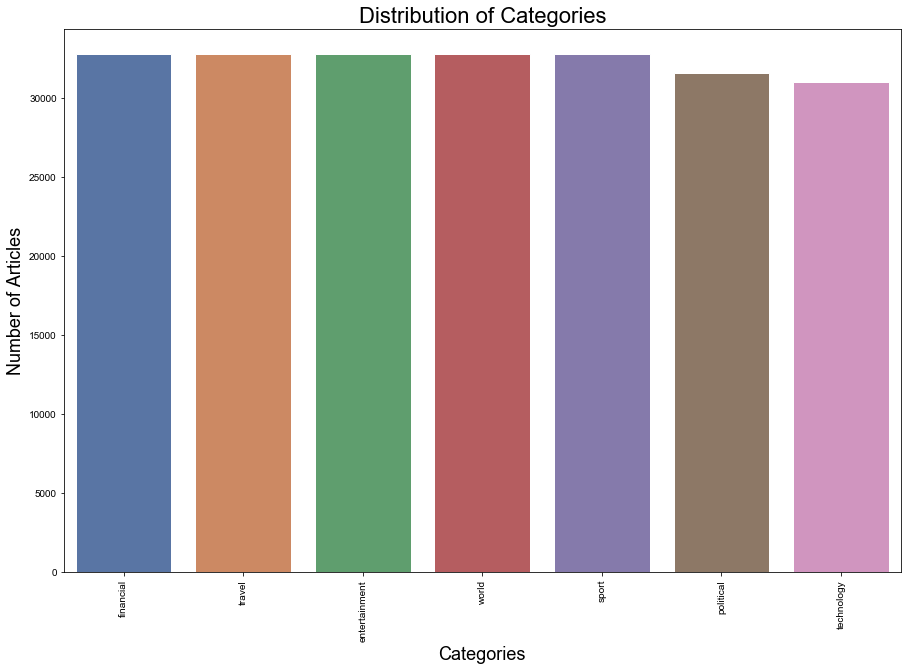

In [232]:
categories_count = df_all_news_processed['Category'].value_counts()
EDA.display_distribution_matplot(categories_count
                        ,"Distribution of Categories"
                        ,"Categories"
                        ,"Number of Articles")

In [233]:
df_distribution = EDA.count_records_per_label(df_all_news_processed, "Num_Records")
EDA.display_distribution_donut(df_distribution, 'Num_Records', 'Category', 'Dataset distribution after balancing with undersampling method (hover)')

In [237]:
#checkpoint:
#df_all_news_processed.reset_index(drop=True, inplace=True)
#df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_post_dataset_distribution')
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_post_dataset_distribution')
pd.options.display.max_colwidth = 500
df_all_news_processed.head(3)

,Title,Text,Category,Text_TotalWords
0,Tracy Morgan performs first stand-up show since accident,tracy morgan performs first stand-up show since accident tracy morgan coming back bang post facebook tracy morgan performs first stand-up show since accident tracy morgan coming back bang check story http 1rew1aj cancel send link sent end email address posted link posted facebook feed join conver ion find facebook commenting please read conver ion guidelines faqs tracy morgan performs first stand-up show since accident usa today edt 13 actor tracy morgan arrives 67th annual primetime emmy aw...,entertainment,380
1,President Barack Obama interviews author Marilynne Robinson,fcc information president barack obama interviews author ilynne robinson ap photo susan walsh file file 8 file photo president barack obama speaks congressional hispanic caucus institute chci 38th anniversary awards gala washington hillary rodham clinton use private email ser new york ap interview president barack obama one asking questions discussion held last th iowa posted new york review books obama asked pulitzer prize-winning author ilynne robinson faith democracy education writing oba...,entertainment,333
2,"I will perform at night clubs, shows β€“ Pastor Ofori Amponsah",source ghana hitz euphemia akpalu date time 52 pm ofori amponsah highlife-musician-turned-pastor ofori amponsah says perform nightclubs even alcoholic company-sponsored events contracted people actually know secret want reveal told fan added judge laws forbid sale alcohol perform brand ambassador alcoholic beverages said promoting new single alewa features sarkodie officially announced return highlife music interview hitz showbiz fylla amanda jissih ofori amponsah went hibernation releasing ...,entertainment,404


## N-Grams / Buzzwords

#### N-Grams

In [238]:
########## N-GRAMS ###########
t1 = time.time()
articles_split_by_word = NLP.tokenization(df_all_news_processed)

n = 1 #Specify number for N-Grams
occurrences = EDA.find_most_common_n_grams(articles_split_by_word, n)
EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 21 seconds


In [239]:
sorted(occurrences.items(), key=lambda x: x[1], reverse=True)[:30]

[('', 8192),
 ('said', 5414),
 ('sign', 3202),
 ('new', 2239),
 ('percent', 2140),
 ('profile', 1658),
 ('news', 1208),
 ('police', 1079),
 ('china', 1047),
 ('clinton', 963),
 ('trump', 956),
 ('million', 913),
 ('apple', 805),
 ('per', 796),
 ('travel', 789),
 ('bank', 764),
 ('u.s.', 761),
 ('ket', 719),
 ('hotel', 681),
 ('state', 644),
 ('game', 633),
 ('business', 617),
 ('odom', 604),
 ('company', 597),
 ('film', 585),
 ('oil', 575),
 ('obama', 561),
 ('people', 540),
 ('city', 538),
 ('president', 525)]

The most frequent word appears to be empty. That is weird since we stripped off every multiple space including new-line '\n'. Let's see what we've got on tri-grams

In [209]:
########## N-GRAMS ###########
t1 = time.time()
n = 3 #Specify number for N-Grams
occurrences = EDA.find_most_common_n_grams(articles_split_by_word, n)
EDA.process_time(round(time.time()-t1))
sorted(occurrences.items(), key=lambda x: x[1], reverse=True)[:30]

Process completed.
Time taken: 42 seconds


[('indicates required field', 6529),
 ('need profile register', 3096),
 ('tip use comma', 1154),
 (' company news', 711),
 ('new york ap', 495),
 (' today new', 475),
 ('new york city', 449),
 ('new york mets', 437),
 ('president barack obama', 420),
 ('usa today sports', 404),
 (' world news', 388),
 ('rugby world cup', 385),
 ('kansas city royals', 325),
 (' business today', 311),
 (' journal sports', 292),
 ('return video video', 291),
 ('historical chart data', 291),
 ('0 0 0', 273),
 (' journal today', 268),
 ('hillary rodham clinton', 265),
 ('toronto blue jays', 261),
 ('islamic state group', 256),
 ('updated 2 hours', 247),
 ('terms conditions use', 243),
 ('daily fantasy sports', 240),
 ('high school football', 238),
 ('make passion career', 237),
 ('updated 3 hours', 226),
 (' today washington', 210),
 (' version article', 208)]

Again, we see some added space to be recognised as a word. More pecifically for example ' company news' considers to be a trigram while in reality it's a bigram <br/><br/>
Let's remove every word that has less than 1 length and run it again.

In [240]:
########## MAYBE THIS SHOULD HAPPEN BEFORE OUTLIERS REMOVAL? ###########
########## MAYBE IN THE NOTEBOOK WITH THE NOISY WORDS ###########
t1 = time.time()
articles_split_by_word = Cleaner.remove_ghost_words(articles_split_by_word)
#articles_split_by_word.sort_values(ascending=True)
n = 3 #Specify number for N-Grams
occurrences = EDA.find_most_common_n_grams(articles_split_by_word, n)
EDA.process_time(round(time.time()-t1))
sorted(occurrences.items(), key=lambda x: x[1], reverse=True)[:30]

Process completed.
Time taken: 26 seconds


[('indicates required field', 3144),
 ('need profile register', 1745),
 ('tip use comma', 987),
 ('new york ap', 378),
 ('new york city', 323),
 ('historical chart data', 263),
 ('president barack obama', 252),
 ('rugby world cup', 179),
 ('updated 2 hours', 158),
 ('0 0 0', 157),
 ('hillary rodham clinton', 153),
 ('islamic state group', 150),
 ('cents per share', 142),
 ('updated 3 hours', 141),
 ('republican presidential candidate', 140),
 ('los angeles ap', 136),
 ('version article appeared', 133),
 ('registered trekearth members', 133),
 ('updated 1 hour', 133),
 ('star wars force', 131),
 ('return video video', 129),
 ('updated 4 hours', 117),
 ('cnn 300x250 sync', 115),
 ('company news today', 114),
 ('recommended related articles', 114),
 ('new york times', 109),
 ('tokyo film festival', 109),
 ('daily fantasy sports', 108),
 ('salt lake city', 104),
 ('new york mets', 102)]

Now our issue seems to be solved. Let's apply the updates to the whole dataset

In [241]:
df_all_news_processed['Text'] = articles_split_by_word.apply(NLP.rejoin_words)
#count the new number of words per article
df_all_news_processed['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news_processed)

#### Buzzwords

Process completed.
Time taken: 5mins 55secs


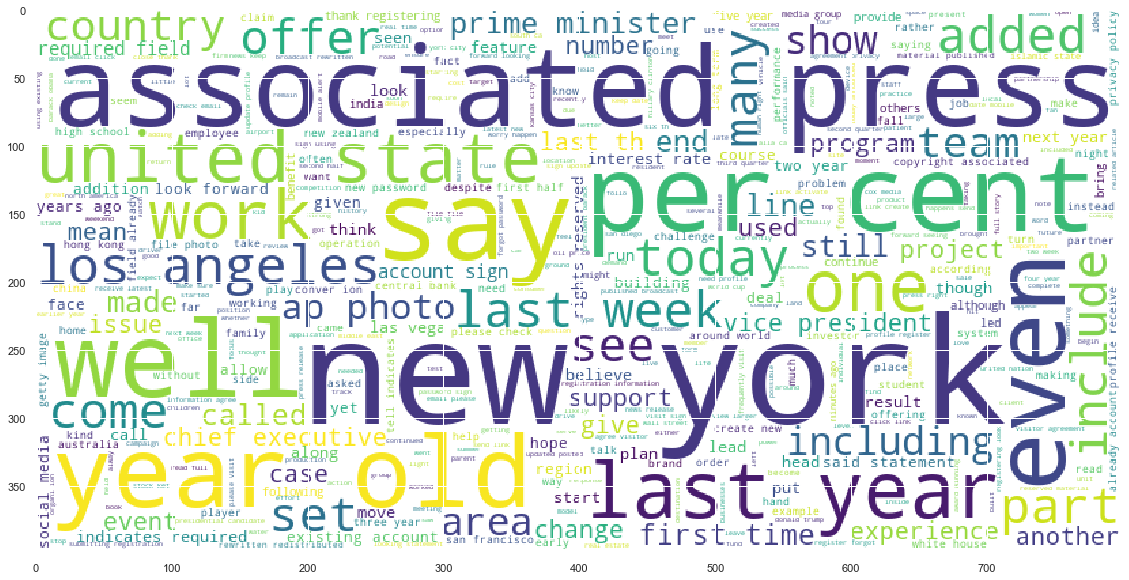

In [273]:
########### Values to configure ###########
 # Values: 'per_class' for each class seperately OR 'all_classes' for one buzzword image
type_of_buzzwords = 'all_classes'

# Values: True or False. Save the images at visuals folder
save_files = True 
###########################################

t1 = time.time()
if(type_of_buzzwords == 'per_class'):
    for cat in df_all_news_processed.Category.unique():
        temp = df_all_news_processed.loc[df_all_news_processed['Category'] == cat]
        EDA.display_buzzwords(list(temp['Text'].values), cat, type_of_buzzwords, save_files)
else:
    EDA.display_buzzwords(list(df_all_news_processed['Text'].values), 'sport', type_of_buzzwords, save_files)

EDA.process_time(round(time.time()-t1))

In [ ]:
'''
buzzwords bechmark on:
my PC: 6 mins
my MAC: 16 GB 1600 MHz DDR3 / 2,5 GHz Quad-Core Intel Core i7
    / articles: 324.965 
    / total number of words: 150.614.863 (with stopwords)
    / process time: 2.631 seconds (around 44 minutes)
'''

In [ ]:
#checkpoint:
#df_all_news_processed.reset_index(drop=True, inplace=True)
#df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_post_ngrams_buzzwords')
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_post_ngrams_buzzwords')
pd.options.display.max_colwidth = 500
df_all_news_processed.head(3)

## NLP Process

In [105]:
df_all_news_processed = df_all_news_processed.copy()[:5]
df_all_news_processed.reset_index(drop=True, inplace=True)
df_all_news_processed

,Title,Text,Category,Text_TotalWords
0,Tracy Morgan performs first stand-up show since accident,tracy morgan performs first stand-up show since accident tracy morgan coming back bang post facebook tracy morgan performs first stand-up show since accident tracy morgan coming back bang check story http on 1rew1aj cancel send link sent end email address posted link posted facebook feed join conver ion find facebook commenting please read conver ion guidelines faqs tracy morgan performs first stand-up show since accident usa today edt 13 actor tracy morgan arrives 67th annual primetime emmy...,entertainment,225
1,President Barack Obama interviews author Marilynne Robinson,fcc information president barack obama interviews author ilynne robinson ap photo susan walsh file file 8 file photo president barack obama speaks congressional hispanic caucus institute chci 38th anniversary awards gala washington hillary rodham clinton use private email ser new york ap interview president barack obama one asking questions discussion held last th iowa posted new york review books obama asked pulitzer prize-winning author ilynne robinson faith democracy education writing oba...,entertainment,178
2,"I will perform at night clubs, shows β€“ Pastor Ofori Amponsah",source ghana hitz euphemia akpalu date time 52 pm ofori amponsah highlife-musician-turned-pastor ofori amponsah says will perform nightclubs even alcoholic company-sponsored events contracted people actually know will will secret want reveal told fan added that judge laws forbid sale alcohol will perform ll brand ambassador alcoholic beverages said promoting new single alewa features sarkodie officially announced return highlife music interview hitz showbiz fylla amanda jissih ofori amponsah...,entertainment,204
3,"MEG Records' Country Star Tom MacLear will be performing his Chart Topping Top 40 Country Single, Unapproachable, at the Sherman Oaks Street Fair",meg records latest music news tom maclear top 40 country singles unapproachable will performed publicly sherman oaks street fair 18th sherman oaks prweb 12 producer singer songwriter tom maclear of meg records often referred man behind curtain one music best kept secrets now emerging toward center stage driving force tom maclear ends evergreen concept band allows maclear perform make music best musicians vocalists business performing sherman oaks street fair 18th 11-1 30pm located ventura bl...,entertainment,230
4,Defeat the Zombie Apocalypse,defeat zombie apocalypse zombie hunting tukwila story entertainment 10 13 zombie-hunting 73864674 join conver ion defeat zombie apocalypse pdt 13 zombie hunting tukwila team evening hunt zombies photo king-tv,entertainment,29


#### Stemming / Lemmatization (if applicable)

In [108]:
# Lemma works. Perhaps use another lemma? https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer
process_to_do = 'lemma' #values 'lemma' or 'stemming' or None
saving = False #True or False to save the dataset as checkpoint

if (process_to_do != None):
    t1 = time.time() 
    articles_split_by_word = NLP.tokenization(df_all_news_processed)

    if (process_to_do == 'lemma'):
        df_all_news_processed['Text'] = NLP.lemmatize(articles_split_by_word)
        #took approx 12 mins on my pc 
        
        df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words)
        if (saving):
            df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_lemmatized')

    elif (process_to_do == 'stemming'):
        df_all_news_processed['Text'] = NLP.stemming(articles_split_by_word)
        #took approx 1h & 5 mins on my pc 
        df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words)
        if (saving):
            df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_stemmed')

EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 0 seconds


#### Spelling Corrections

In [83]:
#https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

'''
Mention about spelling correction using textBlob (see link above):
Fist, say that we don't expect often and major spelling errors since these are articles written by journalists in a formal form. Secondly, it would take tremendous time to proccess all these records. In the end, the added value would be minimal
'''

"\nMention about spelling correction using textBlob (see link above):\nFist, say that we don't expect often and major spelling errors since these are articles written by journalists in a formal form. Secondly, it would take tremendous time to proccess all these records. In the end, the added value would be minimal\n"

#### Entity Recognition

In [ ]:
##### NAME ENTITY RECOGNITION - START #####   
###########################################
'''
MY COMMENTS:
Entity Recognition package of NLTK does not work fully efficiently. It recognises false names.
More importantly is super slow for 10 articles and it would require way better hardware capabilities to run for
my large corpus 300k+ articles.

todo: In the end I will exclude the jar files from the libraries folder and I will just mention 
it as observation to my final report.
'''
from nltk.tag import StanfordPOSTagger
import nltk 
nltk.download('punkt')

import os

java_path = "C:/Program Files/Java/jdk1.8.0_201/bin/java.exe"   
os.environ['JAVAHOME'] = java_path


# Add the jar and model via their path (instead of setting environment variables):
jar = 'libraries/stanford-postagger-full-2020-08-06/stanford-postagger.jar'
model = 'libraries/stanford-postagger-full-2020-08-06/models/english-left3words-distsim.tagger'
pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8')

def find_names(row):
    for sent in nltk.sent_tokenize(row):
        tokens = nltk.tokenize.word_tokenize(sent)
        tags = pos_tagger.tag(tokens)
        print(tags)
        for tag in tags:
            if tag[1] in ["NNP"]:
                print(tag)
        print("-----")
######################################            

df_test=df_all_news_processed[:5].copy()
df_test['Text'] = df_test['Text'].str.upper()
df_test['Text'].apply(find_names) 

##### NAME ENTITY RECOGNITION - END #####     
######################################### 


Way to go: <br/>
0) find noisy words - separate notebook<br/>
1) outliers removal (done) <br/>
2) Balancing dataset (done) <br/>
3) N-Grams + Buzzwords (done) <br/>
4) NLP (stemming/lemmatize) (done) <br/>
5) Data Normalization <br/>

In [111]:
#todo

## Data Normalization

## Main Pipe (Fast-Track Execution)

In [ ]:
''''''''''''''''''' ___MAIN PIPELINE___ '''''''''''''''''''

df_all_news = pd.read_pickle(r'data/original_data/pickles/all_news')

### Cleaning part
df_all_news['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news)

df_all_news.reset_index(drop=True, inplace=True)

df_all_news_processed = df_all_news.copy()
#remove outliers - first phase
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 10] 
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] < 3000] 

df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)
df_all_news_processed = Cleaner.remove_new_line(df_all_news_processed)
df_all_news_processed = Cleaner.remove_non_ascii_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
df_all_news_processed = Cleaner.drop_null_values(df_all_news_processed)
df_all_news_processed = Cleaner.drop_duplicate_values(df_all_news_processed)

In [ ]:
df_all_news_processed

In [ ]:
#N-grams function (done)
#buzzwords function (done)
#sentence encoder (too large texts to visaulise interactively)


df_all_news_processed['Text'] = NLP.to_lower_case(df_all_news_processed, 'Text')
df_all_news_processed = Cleaner.remove_most_noisy_words(df_all_news_processed, 'noisy_words.txt')
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)

In [ ]:
articles_split_by_word = NLP.tokenization(df_all_news_processed)
df_all_news_processed['Text'] = articles_split_by_word.apply(NLP.remove_stop_words)
df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words) 
print("reached here")
df_all_news_processed = Cleaner.remove_punctuation(df_all_news_processed)
df_all_news_processed = Cleaner.remove_single_chars(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)

In [ ]:
df_all_news_processed

In [ ]:
df_all_news_processed = Cleaner.remove_links(df_all_news_processed)
df_all_news_processed = Cleaner.remove_dates(df_all_news_processed)
df_all_news_processed = Cleaner.remove_years(df_all_news_processed)
df_all_news_processed = Cleaner.remove_months(df_all_news_processed)
df_all_news_processed = Cleaner.remove_days(df_all_news_processed)
df_all_news_processed = Cleaner.remove_time(df_all_news_processed)
df_all_news_processed = Cleaner.remove_multiple_spaces(df_all_news_processed)
#CHECKPOINT: Print N-grams

In [ ]:
#lemmatize (if applicable)
#remove outliers
df_all_news['Text_TotalWords'] = EDA.count_words_per_records_opt_2(df_all_news_processed)
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] > 10]
df_all_news_processed = df_all_news_processed[df_all_news_processed['Text_TotalWords'] < 600]

#N-grams function (done)
#buzzwords function (done)



In [ ]:
t1 = time.time() 

articles_split_by_word = NLP.tokenization(df_all_news_processed)
df_all_news_processed['Text'] = NLP.stemming(articles_split_by_word)
df_all_news_processed['Text'] = df_all_news_processed['Text'].apply(NLP.rejoin_words) 

t2 = time.time() 
print("Process completed.\nTime taken:") 
print("{:.2f}".format(round(t2-t1, 2))+" seconds.")

#took 1446 seconds(approx 24 mins) on my pc 

In [ ]:
df_all_news_processed

In [ ]:
#df_all_news_processed.to_pickle('data/original_data/pickles/df_all_news_processed_stemmed')

### Data Normalization & Feature Engineering  (normalize, tf-idf vectors)

In [ ]:
t1 = time.time() 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df_all_news_processed['Text']).toarray()

t2 = time.time() 
print("Process completed.\nTime taken:") 
print("{:.2f}".format(round(t2-t1, 2))+" seconds.")

In [ ]:
X

In [ ]:
t1 = time.time() 

y = df_all_news_processed['Category']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

t2 = time.time() 
print("Process completed.\nTime taken:") 
print("{:.2f}".format(round(t2-t1, 2))+" seconds.")

In [ ]:
y_pred = classifier.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

### Model selection (SVM + kNN + naiveBayes + logistic regression on textual data?)

In [ ]:
pd.options.display.max_colwidth = 500
df_all_news_processed.loc[df_all_news_processed['Category'] == 'travel']

In [ ]:
'''######################## Find N-Grams ########################
from collections import Counter
from itertools import chain

#This function is called from find_most_common_n_grams()
def find_ngrams(input_list, n, n_common_words):
    return list(zip(*[input_list[i:] for i in range(n)]))


########### [Input] ###########
########## df: The DataFrame with the data that would like to process
########## n: The number of N-grams 
########## n_top_ngrams: The number the X most common N-grams
########## Returns: A list with the X most common N-grams and their occurrences 
def find_most_common_n_grams(df, n, n_top_ngrams):
    
    n_grams_title = str(n) +'_grams'
    
    df[n_grams_title] = df['Text'].map(lambda x: find_ngrams(x.split(" "), n, 10))
    
    ngrams = df[n_grams_title].tolist()
    ngrams = list(chain(*ngrams))

    #TODO this: should have x,y,z as the n increases 
    # e.g. [(x.lower(), y.lower(), z.lower()) for x,y,z in ngrams] #--> For 3-grams etc.
    #ngrams = [(x.lower(), y.lower()) for x,y in ngrams]

    ngram_counts = Counter(ngrams)
    return ngram_counts.most_common(n_top_ngrams)

#4 stands for: fourgrams. Change to any n value
#20 stands for: display the top 20 n-grams
testing = find_most_common_n_grams(df_all_news_processed, 4, 20)'''

In [ ]:
'''######## SERIAL CLEANING STEPS ######
Remove new line
Remove non-ascii chars
Remove multiple spaces
Remove null values
Remove duplicate values
Remove noisy pre-defined words (by list) / n-grams (to-do)
Remove punctuations
to lower(NLP)
Remove single chars
Remove links
Remove years
Remove months (to do)
Remove days
Remove time
Remove multiple spaces
Remove stopwords(NLP)

Remove outliers(EDA)'''